In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import time
import numpy as np
import matplotlib.pyplot as plt
import math
import torch.onnx
import codecs, json

In [ ]:
g_device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {g_device} device')

Using cpu device


In [ ]:
g_batch_size_train = 100
g_batch_size_test = 1000

def get_dataloader(batch_size, train):
    return torch.utils.data.DataLoader(
                            torchvision.datasets.MNIST('/files/', train=train, download=True,
                            transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                                ])),
                            batch_size=batch_size, shuffle=True)


g_train_loader = get_dataloader(batch_size = g_batch_size_train, train=True)
g_test_loader = get_dataloader(batch_size = g_batch_size_test, train=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



In [ ]:
# def get_face_dataloader(batch_size, train):
#     return torch.utils.data.DataLoader(
#         torchvision.datasets.CelebA('/files/celeba/', train=train, download=True,
#                                     transform=torchvision.transforms.Compose([
#                                                                               torchvision.transforms.ToTensor(),
#                                                                               torchvision.transforms.Normalize(
#                                                                                   (0.1307,)
#                                                                               )
#                                     ])
#     )
#     return torch.utils.data.DataLoader(
#                             torchvision.datasets.MNIST('/files/', train=train, download=True,
#                             transform=torchvision.transforms.Compose([
#                                 torchvision.transforms.ToTensor(),
#                                 torchvision.transforms.Normalize(
#                                  (0.1307,), (0.3081,))
#                                 ])),
#                             batch_size=batch_size, shuffle=True)

In [ ]:
g_latent_space_size = 2

class Encoder(nn.Module):
    def __init__(self, latent_size=2):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        # self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, latent_size)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        # x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

# test_encoder = Encoder()

# test_x0, _ = next(iter(g_train_loader))
# test_output = encoder(test_x0)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_size=2):
        super().__init__()
        
        self.convT1 = nn.ConvTranspose2d(10, 1, kernel_size=5)
        self.convT2 = nn.ConvTranspose2d(20, 10, kernel_size=5)
        # self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(50, 320)
        self.fc2 = nn.Linear(latent_size, 50)

    def forward(self, x):
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc1(x))
        x = x.view(-1, 20, 4, 4)

        x = F.interpolate(x, scale_factor = 2, mode='nearest')
        x = self.convT2(x)
        x = F.relu(x)

        x = F.interpolate(x, scale_factor = 2, mode='nearest')
        x = self.convT1(x)
        x = torch.sigmoid(x)

        return x

# test_decoder = Decoder()
# test_reconstruction = decoder(test_output)

In [ ]:
def step_autoencoder(model, criterion, loader, optimizer, train=True):
    if train:
        model.train() # sets the module in training mode.
    else:
        model.eval()

    total_loss = 0.0
    total_n = 0
    device = next(model.parameters()).device

    for X, _ in loader:
        X = X.to(device)

        if train:
            optimizer.zero_grad()

        X_out = model(X)

        losses = criterion(X_out, X)

        total_loss += losses.sum().item()

        if train:
            batch_loss = losses.mean()
            batch_loss.backward()
            optimizer.step()

        total_n += X.shape[0]

    loss = total_loss / total_n
    return loss

In [ ]:
g_mseloss = torch.nn.MSELoss(reduction='none')
def AE_Loss(X_out, X):
    losses = g_mseloss(X_out, X)
    losses = losses.view(losses.shape[0], -1) # flattening losses, keeping batch dimension 0
    losses = losses.sum(dim=1)
    return losses

In [ ]:
def train_and_plot(model, optimizer, criterion, epochs=3):
    
    start = time.time()

    train_losses = np.empty(epochs)
    test_losses = np.empty(epochs)
    
    for epoch in range(epochs):
        train_losses[epoch] = step_autoencoder(model=model, criterion=criterion, loader=g_train_loader, optimizer=optimizer)
        test_losses[epoch] =  step_autoencoder(model=model, criterion=criterion, loader=g_test_loader, optimizer=optimizer, train=False)
        print("epoch {}: Test Loss {}".format(epoch, test_losses[epoch]))
        
    print("time: {}".format(time.time() - start))

    plt.plot(range(len(train_losses)), train_losses, label="Train Loss",)
    plt.plot(range(len(test_losses)), test_losses, label="Test Loss", alpha=0.9)
    plt.legend()
    plt.show()

epoch 0: Test Loss 555.1094125
epoch 1: Test Loss 525.94505625
epoch 2: Test Loss 517.0244625
time: 175.27761721611023


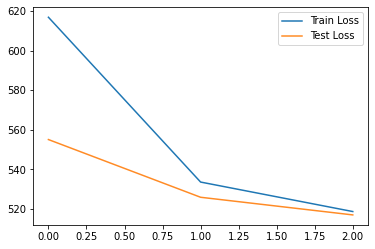

In [ ]:
g_encoder = Encoder()
g_decoder = Decoder()

g_model = nn.Sequential(g_encoder, g_decoder)
g_model.to(g_device)
g_optimizer = torch.optim.Adam(params=g_model.parameters(), lr=0.001)

train_and_plot(model=g_model, optimizer=g_optimizer, criterion=AE_Loss, epochs=3)
# cpu
# time: 166.18881392478943
# Test Loss: 0.539204965877533

In [ ]:
# train_and_plot(model=g_model, optimizer=g_optimizer, criterion=AE_Loss, epochs=2)

In [ ]:
def show_images(X):
    fig = plt.figure()
    X = X.detach().to('cpu')
    n = X.shape[0]
    nrows = 3
    ncols = math.ceil(n / nrows)

    for i in range(n):
        plt.subplot(nrows, ncols, i+1)
        plt.tight_layout()
        plt.imshow(X[i][0], cmap='gray', interpolation='none')
        plt.xticks([])
        plt.yticks([])
    plt.show()

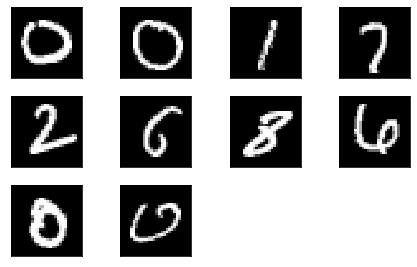

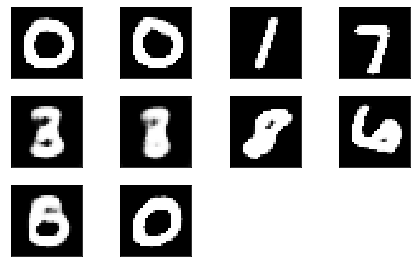

In [ ]:
g_test_examples, _ = next(iter(g_test_loader))
g_test_examples = g_test_examples[:10, :].to(g_device)

show_images(g_test_examples)
show_images(g_model(g_test_examples))

torch.Size([1000, 1, 28, 28])


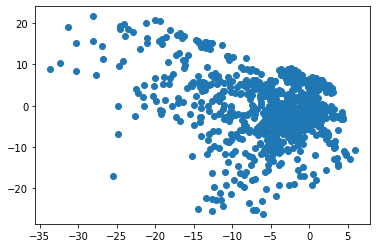

In [ ]:
def visualize_latent_space(X):
    X = X.to(next(g_encoder.parameters()).device)
    Z = g_encoder(X)
    Z = Z.to('cpu').detach()

    plt.scatter(Z[:, 0], Z[:, 1])

g_examples_loader = get_dataloader(batch_size = 1000, train=False)
g_test_examples, _ = next(iter(g_examples_loader))
print(g_test_examples.shape)

visualize_latent_space(g_test_examples)

In [ ]:
class To_Canvas_Format(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x = x[0, :] # only one image, not whole batch
        x = torch.mul(x, 255).type(torch.uint8).repeat(3,1,1) # from grayscale to rgb
        x = F.pad(x, (0,0, 0,0, 0,1), value=255) # from rgb to rgba

        x = torch.permute(x, (1,2,0)) # set to pixel.x, pixel.y, rgba
        return x

In [ ]:
# # exporting the model

def export_onnx(model, dummy_input, file_name):
    torch.onnx.export(  model,                     # model being run
                        dummy_input,               # model input (or a tuple for multiple inputs)
                        file_name,                      # where to save the model (can be a file or file-like object)
                        export_params=True,        # store the trained parameter weights inside the model file
                        opset_version= 14,          # the ONNX version to export the model to
                        do_constant_folding=True,  # whether to execute constant folding for optimization
                        input_names = ['input'],   # the model's input names
                        output_names = ['output'], # the model's output names
                        dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                      'output' : {0 : 'batch_size'}})

g_encoder.to(g_device)
g_decoder.to(g_device)
g_tocanvas = To_Canvas_Format().to(g_device)
g_decoder_export = nn.Sequential(g_decoder, g_tocanvas)

g_dummy_input, g_dummy_input_y = next(iter(g_test_loader))
g_dummy_input = g_dummy_input.to(g_device)

g_dummy_latent = g_encoder(g_dummy_input)
g_dummy_output = g_decoder_export(g_dummy_latent)

export_onnx(model=g_encoder, dummy_input=g_dummy_input, file_name="encoder.onnx")
export_onnx(model=g_decoder_export, dummy_input=g_dummy_latent, file_name="decoder.onnx")

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:716: UserWarning: allowzero=0 by default. In order to honor zero value in shape use allowzero=1
  warnings.warn("allowzero=0 by default. In order to honor zero value in shape use allowzero=1")


In [ ]:
# output some example data as json

def export_data_to_json(dataloader, n, name):
    export_list_X = []
    export_list_Y = []
    for X, Y in dataloader:
        taking = min(len(X), n-len(export_list_X))
        if taking <= 0:
            break
        export_list_X.extend(X.tolist())
        export_list_Y.extend(Y.tolist())
    json.dump(export_list_X, codecs.open(name+"_X.json", 'w', encoding='utf-8'), 
            separators=(',', ':'), 
            indent=4)
    json.dump(export_list_Y, codecs.open(name+"_Y.json", 'w', encoding='utf-8'), 
            separators=(',', ':'),
            indent=4)

export_data_to_json(g_test_loader, 5000, "mnist")

In [ ]:
#################  VAE  ##################

class VAE(nn.Module):
    def __init__(self, latent_size=2):
        super().__init__()
        self.latent_size = latent_size
        self.encoder = Encoder(latent_size*2)
        self.decoder = Decoder(latent_size)
    
    def forward(self, X):
        X = self.encoder(X)
        mu, log_var = torch.split(X, self.latent_size, dim=1)

        Z_0 = torch.randn_like(mu)
        Z = Z_0 * torch.exp(0.5 * log_var) + mu

        X = self.decoder(Z)
        
        # we need to also return the KL term for the loss:
        KL = -0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim=1)

        # KL = torch.zeros_like(KL) # TODO remove, just seeing what happens
        
        return (X, KL)

def VAE_Loss(model_output, X):
    X_out, KL = model_output
    return AE_Loss(X_out, X) + KL

g_vae = VAE()
foo_modelin = next(iter(g_test_loader))[0]
foo_modelout = g_vae(foo_modelin)
print(VAE_Loss(foo_modelout, foo_modelin).shape)

torch.Size([1000])


In [ ]:
g_vae = VAE()
g_vae.to(g_device)
g_vae_optimizer = torch.optim.Adam(params=g_vae.parameters(), lr=0.001)

epoch 0: Test Loss 545.36024375
epoch 1: Test Loss 532.4943375
epoch 2: Test Loss 526.816471875
epoch 3: Test Loss 519.22805
epoch 4: Test Loss 517.6081125
time: 297.6318690776825


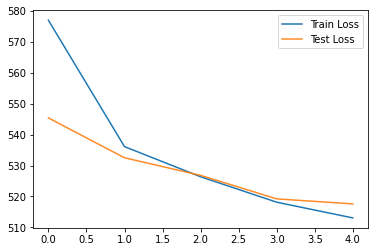

epoch 0: Test Loss 513.242665625
epoch 1: Test Loss 510.874478125
epoch 2: Test Loss 509.54469375
epoch 3: Test Loss 508.206778125
epoch 4: Test Loss 506.320559375
time: 308.8749141693115


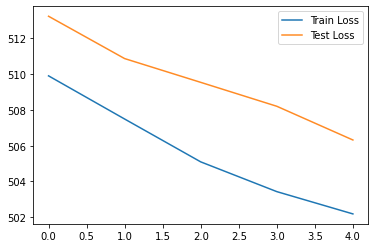

epoch 0: Test Loss 504.855334375
epoch 1: Test Loss 504.988096875
epoch 2: Test Loss 503.398965625
epoch 3: Test Loss 503.19919375
epoch 4: Test Loss 503.57635625
time: 307.4080080986023


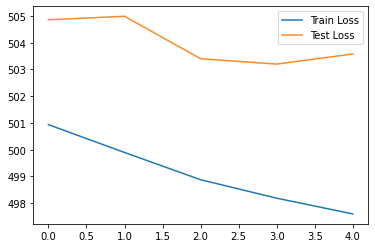

epoch 0: Test Loss 502.178034375
epoch 1: Test Loss 501.38411875
epoch 2: Test Loss 503.23866875
epoch 3: Test Loss 500.854584375
epoch 4: Test Loss 500.758784375
time: 306.0238518714905


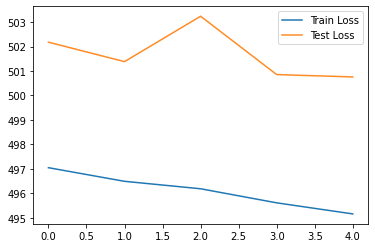

In [ ]:
train_and_plot(model=g_vae, optimizer=g_vae_optimizer, epochs=5, criterion = VAE_Loss)
train_and_plot(model=g_vae, optimizer=g_vae_optimizer, epochs=5, criterion = VAE_Loss)
train_and_plot(model=g_vae, optimizer=g_vae_optimizer, epochs=5, criterion = VAE_Loss)
train_and_plot(model=g_vae, optimizer=g_vae_optimizer, epochs=5, criterion = VAE_Loss)

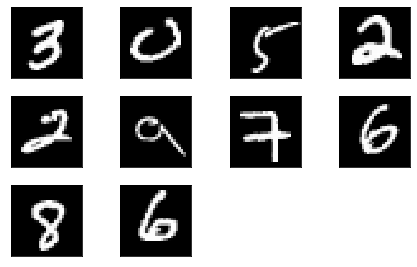

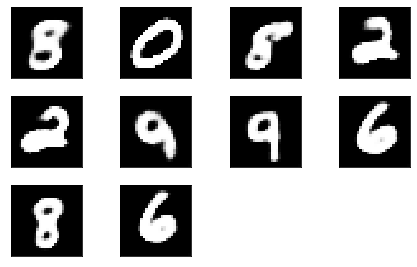

In [ ]:
g_test_examples, _ = next(iter(g_test_loader))
g_test_examples = g_test_examples[:10, :].to(g_device)

show_images(g_test_examples)
g_vae_X_out, _ = g_vae(g_test_examples)
show_images(g_vae_X_out)

epoch 0: Test Loss 500.53235
epoch 1: Test Loss 499.961065625
epoch 2: Test Loss 500.40820625
epoch 3: Test Loss 500.059234375
epoch 4: Test Loss 499.537071875
time: 308.0777769088745


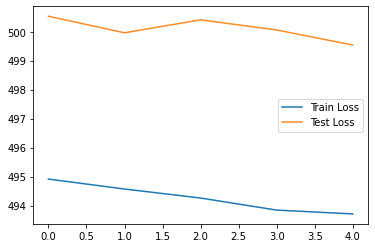

In [ ]:
g_vae_optimizer.lr = 0.0001
train_and_plot(model=g_vae, optimizer=g_vae_optimizer, epochs=5, criterion = VAE_Loss)

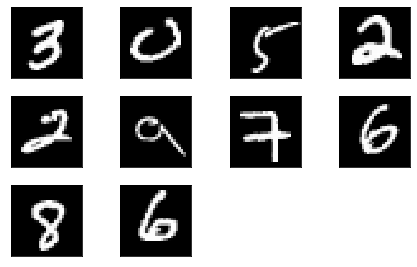

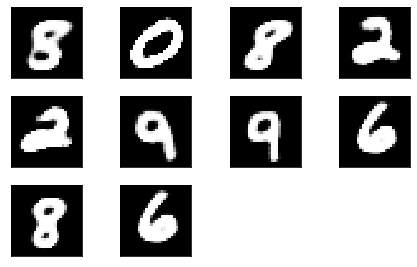

In [ ]:
show_images(g_test_examples)
g_vae_X_out, _ = g_vae(g_test_examples)
show_images(g_vae_X_out)

epoch 0: Test Loss 499.674203125
epoch 1: Test Loss 499.114309375
epoch 2: Test Loss 498.495415625
epoch 3: Test Loss 498.598459375
epoch 4: Test Loss 499.0768375
time: 519.7243065834045


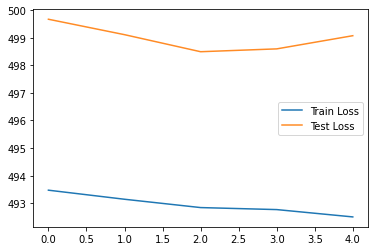

In [ ]:
g_vae_optimizer.lr = 0.00001
train_and_plot(model=g_vae, optimizer=g_vae_optimizer, epochs=5, criterion = VAE_Loss)

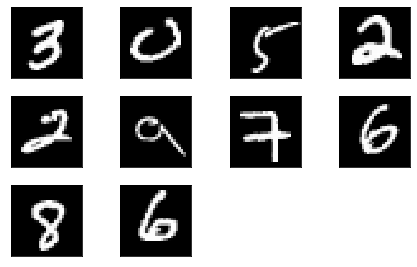

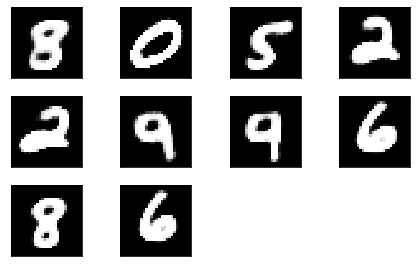

In [ ]:
show_images(g_test_examples)
g_vae_X_out, _ = g_vae(g_test_examples)
show_images(g_vae_X_out)

In [ ]:
class VAE_to_encoder(nn.Module):
    def __init__(self, vae):
        super().__init__()
        self.encoder = vae.encoder
        self.latent_size = vae.latent_size
    
    def forward(self, X):
        X = self.encoder(X)
        mu, log_var = torch.split(X, self.latent_size, dim=1)
        return mu

In [ ]:
g_vae.to(g_device)
g_vae_tocanvas = To_Canvas_Format().to(g_device)
g_vae_decoder_export = nn.Sequential(g_vae.decoder, g_tocanvas)
g_vae_encoder = VAE_to_encoder(g_vae)

g_vae_dummy_input, g_vae_dummy_input_y = next(iter(g_test_loader))
g_vae_dummy_input = g_vae_dummy_input.to(g_device)

g_vae_dummy_latent = g_vae_encoder(g_vae_dummy_input)
g_vae_dummy_output = g_vae_decoder_export(g_vae_dummy_latent)

export_onnx(model=g_vae_encoder, dummy_input=g_vae_dummy_input, file_name="vae_encoder.onnx")
export_onnx(model=g_vae_decoder_export, dummy_input=g_vae_dummy_latent, file_name="vae_decoder.onnx")

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:716: UserWarning: allowzero=0 by default. In order to honor zero value in shape use allowzero=1
  warnings.warn("allowzero=0 by default. In order to honor zero value in shape use allowzero=1")
